In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [3]:
df, mat = read_annotated_peaks('./ann_raw_kc_control_atac_peaks_all.txt')


In [4]:
best_reps = [
    '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
    '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
    '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
    '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
    '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
    '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208']

In [5]:
# import annotation file
df, mat = read_annotated_peaks('./ann_raw_kc_control_atac_peaks_all.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./ann_raw_kc_control_atac_peaks_filtered.txt', sep='\t')

In [6]:
df.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,Gene Name,Gene Alias,Gene Description,Gene Type,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208,/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr3-105041710-1,chr3,105041210,105042210,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,"intron (NM_030249, intron 1 of 5)","intron (NM_030249, intron 1 of 5)",11243.0,NM_001163332,...,Cttnbp2nl,AA552995|AA589392|AU018624|BC003236|mKIAA1433,CTTNBP2 N-terminal like,protein-coding,60.0,136.0,47.0,52.0,70.0,68.0
Merged-chr9-104408103-3,chr9,104407597,104408597,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,Intergenic,Intergenic,-18016.0,NR_035516,...,Mir2136,mmu-mir-2136,microRNA 2136,ncRNA,125.0,316.0,160.0,217.0,246.0,239.0
Merged-chr1-64374970-2,chr1,64374473,64375473,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,Intergenic,Intergenic,-157831.0,NM_009952,...,Creb1,2310001E10Rik|3526402H21Rik|AV083133|Creb|Creb-1,cAMP responsive element binding protein 1,protein-coding,207.0,587.0,351.0,369.0,472.0,565.0
Merged-chr16-45757609-1,chr16,45757109,45758109,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,"intron (NM_001357078, intron 13 of 16)","intron (NM_001357078, intron 13 of 16)",-14654.0,NM_172511,...,Abhd10,-,abhydrolase domain containing 10,protein-coding,6.0,12.0,15.0,12.0,13.0,7.0
Merged-chr3-153571995-1,chr3,153571495,153572495,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,"intron (NM_011372, intron 1 of 4)","intron (NM_011372, intron 1 of 4)",153138.0,NM_011372,...,St6galnac3,Siat7c,"ST6 (alpha-N-acetyl-neuraminyl-2,3-beta-galact...",protein-coding,132.0,415.0,158.0,215.0,138.0,222.0


In [7]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./ann_raw_kc_control_atac_peaks_filtered.txt \
# 00_c57 00_c57 \
# 01_balbc 01_balbc \
# 02_aj 02_aj \
# -AvsA -peaks > ./diff_output.txt


### Import differential peaks

In [8]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_output.txt',
    './ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (43605, 24)
getDiffExpression selected transcripts (42636, 33)
annotatePeaks selected peaks (42636, 24)


Check top peaks on browser to ensure everything worked properly

In [9]:
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)
diff_peak.sort_values('00_c57 vs. 01_balbc adj. p-value', ascending=True).head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,00_c57 vs. 01_balbc Log2 Fold Change,00_c57 vs. 01_balbc p-value,00_c57 vs. 01_balbc adj. p-value,00_c57 vs. 02_aj Log2 Fold Change,00_c57 vs. 02_aj p-value,00_c57 vs. 02_aj adj. p-value,01_balbc vs. 02_aj Log2 Fold Change,01_balbc vs. 02_aj p-value,01_balbc vs. 02_aj adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr11-3157012-1,chr11,3156512,3157512,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,"intron (NM_030207, intron 11 of 32)","intron (NM_030207, intron 11 of 32)",32991.0,NR_003517,...,5.702800,2.130506e-45,8.555260e-41,5.071521,7.064990e-30,1.990017e-26,-0.626029,0.045476,0.544636,chr11:3156512-3157512
Merged-chr11-3157659-1,chr11,3157159,3158159,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,"intron (NM_030207, intron 11 of 32)","intron (NM_030207, intron 11 of 32)",33638.0,NR_003517,...,4.903471,2.007736e-40,4.031133e-36,4.416116,8.040750e-28,1.699391e-24,-0.486942,0.099988,0.743703,chr11:3157159-3158159
Merged-chr19-5407318-1,chr19,5406818,5407818,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,"intron (NR_027938, intron 1 of 3)",B3|SINE|B2,503.0,NR_027938,...,-3.483913,9.121811e-37,1.220985e-32,-3.198889,2.008853e-31,7.333410e-28,0.288129,0.414114,0.993356,chr19:5406818-5407818
Merged-chr17-71265864-2,chr17,71265345,71266345,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,"intron (NM_001357338, intron 4 of 7)","intron (NM_001357338, intron 4 of 7)",45166.0,NM_001357337,...,4.063152,9.843985e-36,9.882377e-32,4.209051,6.122532e-41,1.229282e-36,0.147797,0.504927,0.999839,chr17:71265345-71266345
Merged-chr17-36121540-1,chr17,36121040,36122040,+,1000.0,/gpfs/data01/glasslab/home/h1bennet/strains/re...,promoter-TSS (NR_046286),promoter-TSS (NR_046286),-96.0,NR_046286,...,-3.627987,8.368064e-31,6.720560e-27,-3.623820,8.929686e-35,5.122578e-31,0.009061,0.985504,0.999839,chr17:36121040-36122040


In [10]:
# pull out selected samples
cols = np.append(np.asarray([True]*18, 'bool'), peak_mat.columns.str.contains('|'.join(best_reps)))
peaks = peaks.loc[:, cols]
peak_mat = peak_mat.loc[:, peak_mat.columns.str.contains('|'.join(best_reps))]

In [11]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [12]:
comps = ['00_c57 vs. 01_balbc',
         '00_c57 vs. 02_aj',
         '01_balbc vs. 02_aj']
cols = [[0,1,2,3],
        [0,1,4,5],
        [2,3,4,5]]

groups = [[[0,1],[2,3]],
         [[0,1],[4,5]],
         [[2,3],[4,5]]]

colors = [['#4daf4a', '#377eb8'],
          ['#4daf4a', '#e41a1c'],
          ['#377eb8', '#e41a1c']]

In [13]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < 0)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 0)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,14.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(14.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    plt.close()

00_c57 vs. 01_balbc
N genes downregulated 1418
N genes upregulated 1196

00_c57 vs. 02_aj
N genes downregulated 1555
N genes upregulated 947

01_balbc vs. 02_aj
N genes downregulated 592
N genes upregulated 352



# Cluster differential enhancers:

In [14]:
comps = ['00_c57 vs. 01_balbc',
         '00_c57 vs. 02_aj',
         '01_balbc vs. 02_aj']

3569


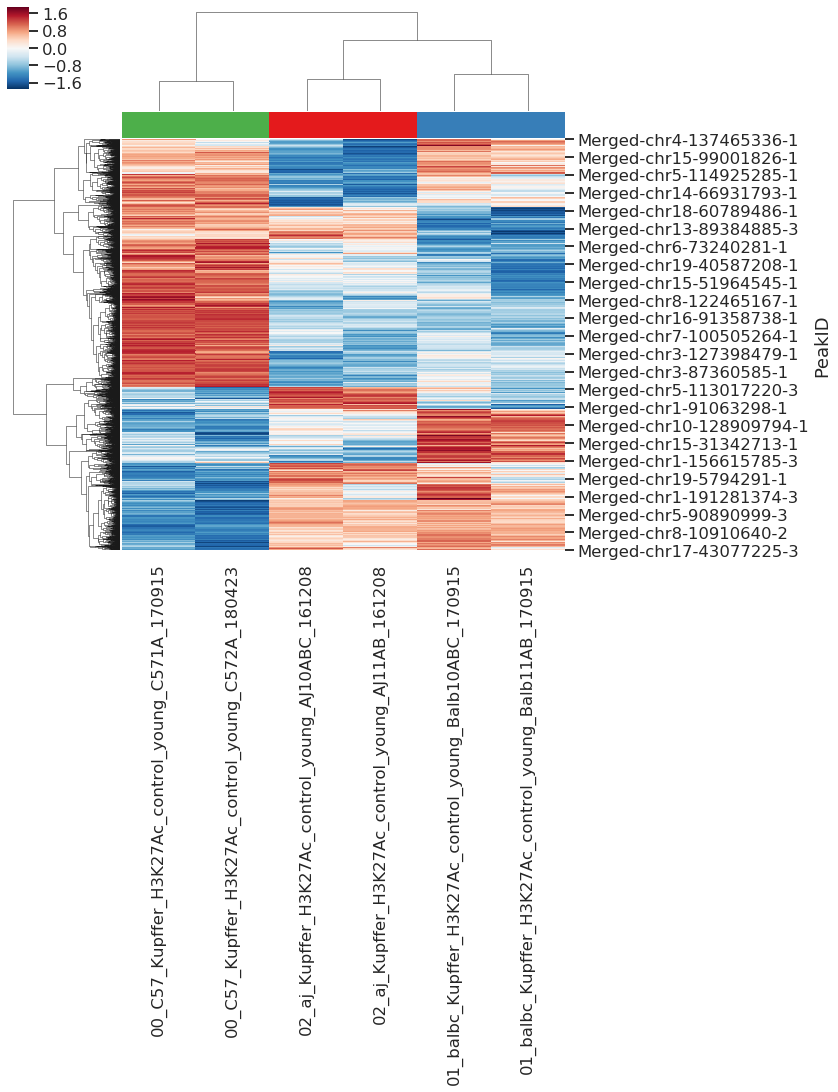

In [15]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#4daf4a', '#4daf4a', '#377eb8', '#377eb8', '#e41a1c', '#e41a1c'])
plt.savefig('./figures/stellate_diff_genes_clustermap.png', bbox_inches='tight')

perform with distal enhancers

2796


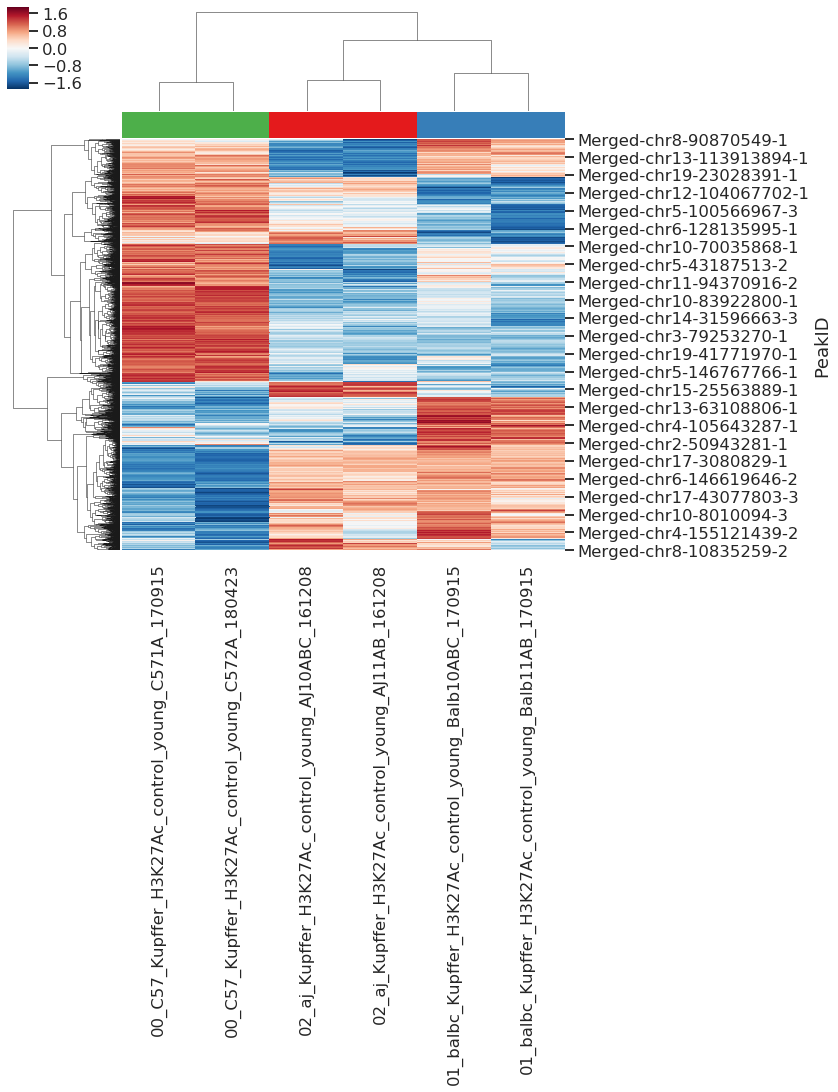

In [16]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#4daf4a', '#4daf4a', '#377eb8', '#377eb8', '#e41a1c', '#e41a1c'])
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Save differential peaks for analysis in GREAT

In [14]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['00_pu1_4month',
         '01_pu1_25month']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_pu1_4month ...

0
For comp: 00_c57 vs. 01_balbc


NameError: name 'u' is not defined